In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_path = '/content/drive/MyDrive/dataset2'

dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
model = SimpleCNN(num_classes=len(dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

Epoch 1/10, Train Loss: 4.3592, Train Accuracy: 3.09%, Val Loss: 3.3916, Val Accuracy: 2.44%
Epoch 2/10, Train Loss: 2.7407, Train Accuracy: 35.80%, Val Loss: 2.6663, Val Accuracy: 24.39%
Epoch 3/10, Train Loss: 1.7341, Train Accuracy: 74.69%, Val Loss: 2.0651, Val Accuracy: 51.22%
Epoch 4/10, Train Loss: 0.6536, Train Accuracy: 90.12%, Val Loss: 1.6627, Val Accuracy: 48.78%
Epoch 5/10, Train Loss: 0.3353, Train Accuracy: 97.53%, Val Loss: 1.4828, Val Accuracy: 65.85%
Epoch 6/10, Train Loss: 0.0912, Train Accuracy: 98.77%, Val Loss: 1.7249, Val Accuracy: 58.54%
Epoch 7/10, Train Loss: 0.0398, Train Accuracy: 99.38%, Val Loss: 1.7270, Val Accuracy: 65.85%
Epoch 8/10, Train Loss: 0.0100, Train Accuracy: 100.00%, Val Loss: 1.7944, Val Accuracy: 63.41%
Epoch 9/10, Train Loss: 0.0052, Train Accuracy: 100.00%, Val Loss: 1.8719, Val Accuracy: 65.85%
Epoch 10/10, Train Loss: 0.0025, Train Accuracy: 100.00%, Val Loss: 1.9290, Val Accuracy: 65.85%


Precision: 0.6258
Recall: 0.6792
Accuracy: 0.6585
F1 Score: 0.6054
      Metric     Value
0  Precision  0.625833
1     Recall  0.679167
2   Accuracy  0.658537
3   F1 Score  0.605357


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

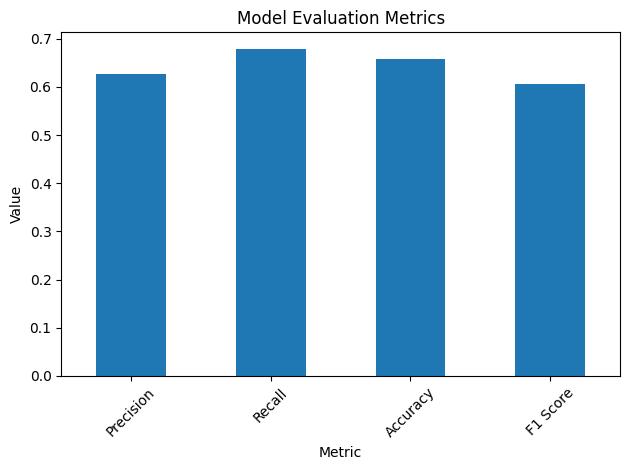

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Evaluate the model on the validation set
model.eval()
val_predictions = []
val_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(val_targets, val_predictions, average='macro')
recall = recall_score(val_targets, val_predictions, average='macro')
accuracy = accuracy_score(val_targets, val_predictions)
f1 = f1_score(val_targets, val_predictions, average='macro')

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create a table of evaluation metrics
import pandas as pd

metrics_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1 Score'],
    'Value': [precision, recall, accuracy, f1]
})

print(metrics_table)

# Plot the evaluation metrics
plt.figure(figsize=(8, 6))
metrics_table.plot(kind='bar', x='Metric', y='Value', legend=None)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

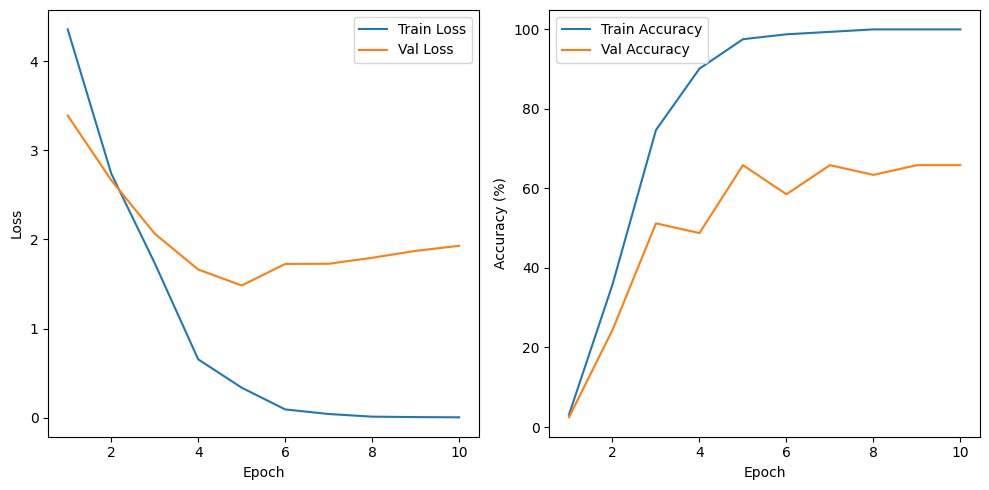

In [14]:
# Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'classification_model.pth')

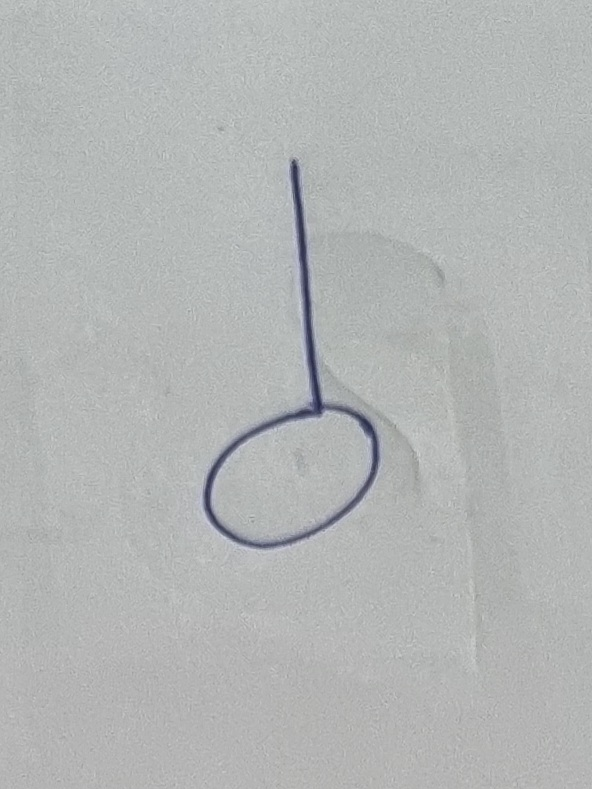

In [18]:
# image_path = '/content/drive/MyDrive/dataset2/va/20240210_005351.jpg'

image_path = '/content/drive/MyDrive/dataset2/va/20240210_005351.jpg'


Image.open(image_path)

In [19]:
import random
from PIL import Image
import torch

# Load the trained model
model.load_state_dict(torch.load('classification_model.pth'))
model.eval()

image = Image.open(image_path)


image = transform(image)

image = image.cpu().squeeze(0).unsqueeze(0)


# Make a prediction
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)

# Print the prediction
print(f"Predicted class: {dataset.classes[predicted.item()]}")

Predicted class: va
